In [2]:
import pandas as pd
from numpy import radians, sin, cos, arccos
import numpy as np
import time
from datetime import datetime
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from zipfile import ZipFile
import datetime
import math
data_path = 'data/'

In [3]:
# Helper function which finds the distance between two points from their latitude and lonigutde coordinates
# It is used in the next parts

def find_distance(lat1, lat2, lon1, lon2):
    ### This fonction takes four columns of a dataframe and returns the column with all the distances
    ### calculated point by point.
    earth_radius = 6373 # In km
    lat1 = lat1/180 * math.pi
    lat2 = lat2/180 * math.pi
    dlat = lat2 - lat1
    dlon = (lon1 - lon2)/180 * math.pi
    a = (dlat/2).apply(math.sin)**2 + lat1.apply(math.cos) * lat2.apply(math.cos) * (dlon/2).apply(math.sin)**2
    c = 2 * (a.apply(math.sqrt) / (1 - a).apply(math.sqrt)).apply(math.atan)
    d = earth_radius * c
    distance_db = pd.DataFrame(d).rename(columns = {0 : 'distance'})
    return(distance_db)
# For each user, we want to assign them to one square (the one in which they checked-in the most).*
# In order to do so, we create a column named "my_square" which gives the name of the square in which each column
# is in. We take latitude = 0 and longitude = 0 to be the centre of the origin square.
# The names of our 25km * 25km squares are chosen as the tuple (latitude, longitude)

# In order to make our code more compact we create a function to create our labeling of squares.

def square_label(my_dataframe):
    inter = pd.DataFrame()
    cos_latitude = (my_dataframe['latitude']/180 * math.pi).apply(math.cos)
    inter["rounded_latitude"] = (110.574 * (my_dataframe['latitude'])/25).apply(round)
    inter["rounded_longitude"] = (111.320 * cos_latitude* (my_dataframe['longitude'])/25).apply(round)
    inter_list = inter.values.tolist()
    my_dataframe['my_square'] = [tuple(val) for val in inter_list]
    return(my_dataframe)
# For each user, we get the number of times where they checked in in a given location. We associate the position
# of their home with the position of the location where they checked in the most.

# In case of a draw (a user checked in the same number of times in two locations), we average the position of the
# house over the position of the most checked in locations.

# No need to re-run these lines if you have run the previous cells

def find_homes_avg(dataframe):
    grouped_data = dataframe.groupby(["user", "my_square"]).count()
    grouped_data = grouped_data.reset_index().drop(columns = ["locid"])
    # We start by getting all the values where there was a draw. (Takes a few minutes)
    # We then extract just the columns "user" and "my_square" to work on them.
    draw_data = grouped_data.groupby("user").apply(lambda x: x.loc[x["time"] == x["time"].max()])
    draw_value = pd.DataFrame(draw_data[["user", "my_square"]].values).rename(columns = {0 : 'user', 1 : 'my_square'})
    return(draw_value)
# Once we have filtered our home data, we can do our average over the right "my_square"
def compute_house_position(dataframe, home_data):
    dataframe = dataframe.merge(home_data, how = "inner", left_on = ["user", "my_square"], right_on = ["user", "my_square"])
    return(dataframe.groupby("user")[["latitude", "longitude"]].mean())

# At first, we think of doing a left join between gowalla_edges and our house position dataframe. We however realize
# that some users never checked in and therefore have no addresses.
# We therefore decide to do an inner join.

def join_homes_and_user(dataframe, home_data):
    first_join = dataframe.merge(home_data, left_on = "friend", right_on = "user").rename(columns = {"latitude" : "friend latitude", "longitude" : "friend longitude"})
    second_join = first_join.merge(home_data, left_on = "pal", right_on = "user").rename(columns = {"latitude" : "pal latitude", "longitude" : "pal longitude"})
    return(second_join)

In [4]:
US_checkins = pd.read_csv(data_path+'1_US_2013_merge_data.csv', names=['locid','user', 'time','year',  'latitude', 'longitude', 'building', 'countries'],header=None, error_bad_lines=False)
US_checkins.drop(0,0,inplace=True)
US_checkins.user = US_checkins.user.astype(int)
US_checkins.latitude = US_checkins.latitude.astype(float)
US_checkins.longitude = US_checkins.longitude.astype(float)
US_checkins.head(10)

C:\Users\Marion Chabrier\.julia\conda\3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,locid,user,time,year,latitude,longitude,building,countries
1,3fd66200f964a52000e71ee3,319827,2013-01-13 00:49:25+00:00,2013,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e71ee3,496140,2013-01-13 01:12:49+00:00,2013,40.733596,-74.003139,Jazz Club,US
3,3fd66200f964a52000e71ee3,288077,2013-02-16 02:29:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
4,3fd66200f964a52000e71ee3,191931,2013-02-17 03:50:53+00:00,2013,40.733596,-74.003139,Jazz Club,US
5,3fd66200f964a52000e71ee3,1402791,2013-02-19 03:48:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
6,3fd66200f964a52000e71ee3,80590,2013-03-15 01:25:06+00:00,2013,40.733596,-74.003139,Jazz Club,US
7,3fd66200f964a52000e71ee3,1967638,2013-03-17 00:29:22+00:00,2013,40.733596,-74.003139,Jazz Club,US
8,3fd66200f964a52000e71ee3,952766,2013-03-17 05:18:40+00:00,2013,40.733596,-74.003139,Jazz Club,US
9,3fd66200f964a52000e71ee3,651362,2013-05-08 04:02:48+00:00,2013,40.733596,-74.003139,Jazz Club,US
10,3fd66200f964a52000e71ee3,100462,2013-05-12 02:31:32+00:00,2013,40.733596,-74.003139,Jazz Club,US


In [5]:
df_friend = pd.read_csv('dataset_WWW_friendship_new.txt', header = None, sep = "\t", names = ["friend", "pal"])
df_friend

,friend,pal
0,15,595326
1,19,54
2,19,1061
3,19,1668
4,19,21596
...,...,...
607328,2166684,2181580
607329,2167183,2175735
607330,2170360,2174239
607331,2173716,2186144


In [6]:
US_checkins = square_label(US_checkins)
US_checkins

,locid,user,time,year,latitude,longitude,building,countries,my_square
1,3fd66200f964a52000e71ee3,319827,2013-01-13 00:49:25+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
2,3fd66200f964a52000e71ee3,496140,2013-01-13 01:12:49+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
3,3fd66200f964a52000e71ee3,288077,2013-02-16 02:29:11+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
4,3fd66200f964a52000e71ee3,191931,2013-02-17 03:50:53+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
5,3fd66200f964a52000e71ee3,1402791,2013-02-19 03:48:11+00:00,2013,40.733596,-74.003139,Jazz Club,US,"(180, -250)"
...,...,...,...,...,...,...,...,...,...
1187593,52b6450811d248b7b0610626,1243714,2013-12-22 01:50:10+00:00,2013,33.873249,-118.387099,Home (private),US,"(150, -438)"
1187594,52b65856498e252aade808b5,120150,2013-12-22 03:12:02+00:00,2013,39.281602,-76.593760,Lounge,US,"(174, -264)"
1187595,52b66bde498e5705ff1ef091,212157,2013-12-22 04:48:06+00:00,2013,33.546776,-117.131694,Other Great Outdoors,US,"(148, -435)"
1187596,52b67f4e498e403b8cccbe27,133864,2013-12-22 06:24:48+00:00,2013,42.331624,-83.066572,Dive Bar,US,"(187, -273)"


In [7]:
home_data_avg = find_homes_avg(US_checkins)
home_positions_avg = compute_house_position(US_checkins, home_data_avg)
home_positions_avg

,latitude,longitude
user,,
19,40.723447,-73.988018
39,40.797902,-73.604889
54,37.766274,-122.430362
58,40.691485,-73.985955
78,40.758735,-73.901430
...,...,...
2173091,38.918054,-77.222156
2174127,38.971024,-94.705508
2174989,26.137223,-80.108706


In [8]:
home_positions_avg = home_positions_avg.reset_index()

In [9]:
df_friend.merge(home_positions_avg, left_on = "friend", right_on = "user").merge(home_positions_avg, left_on = "pal", right_on = "user")

,friend,pal,user_x,latitude_x,longitude_x,user_y,latitude_y,longitude_y
0,19,54,19,40.723447,-73.988018,54,37.766274,-122.430362
1,19,1061,19,40.723447,-73.988018,1061,37.749693,-122.444928
2,866,1061,866,21.305919,-157.857979,1061,37.749693,-122.444928
3,19,1668,19,40.723447,-73.988018,1668,40.725943,-73.993047
4,54,1668,54,37.766274,-122.430362,1668,40.725943,-73.993047
...,...,...,...,...,...,...,...,...
58230,2073933,2149533,2073933,33.961452,-118.427382,2149533,33.996001,-118.431961
58231,2076284,2095717,2076284,38.865423,-104.770159,2095717,38.892645,-104.775632
58232,2076284,2098263,2076284,38.865423,-104.770159,2098263,40.552342,-105.061401
58233,2095717,2098263,2095717,38.892645,-104.775632,2098263,40.552342,-105.061401


In [10]:
friend_home_df_avg = join_homes_and_user(df_friend, home_positions_avg)
friend_home_df_avg

,friend,pal,user_x,friend latitude,friend longitude,user_y,pal latitude,pal longitude
0,19,54,19,40.723447,-73.988018,54,37.766274,-122.430362
1,19,1061,19,40.723447,-73.988018,1061,37.749693,-122.444928
2,866,1061,866,21.305919,-157.857979,1061,37.749693,-122.444928
3,19,1668,19,40.723447,-73.988018,1668,40.725943,-73.993047
4,54,1668,54,37.766274,-122.430362,1668,40.725943,-73.993047
...,...,...,...,...,...,...,...,...
58230,2073933,2149533,2073933,33.961452,-118.427382,2149533,33.996001,-118.431961
58231,2076284,2095717,2076284,38.865423,-104.770159,2095717,38.892645,-104.775632
58232,2076284,2098263,2076284,38.865423,-104.770159,2098263,40.552342,-105.061401
58233,2095717,2098263,2095717,38.892645,-104.775632,2098263,40.552342,-105.061401


In [11]:
distance_db_avg = find_distance(friend_home_df_avg["friend latitude"], friend_home_df_avg["pal latitude"], friend_home_df_avg["friend longitude"], friend_home_df_avg["pal longitude"])
distance_db_avg

,distance
0,4132.862593
1,4134.700170
2,3852.165331
3,0.506725
4,4132.391350
...,...
58230,3.866019
58231,3.064782
58232,189.283143
58233,186.219318


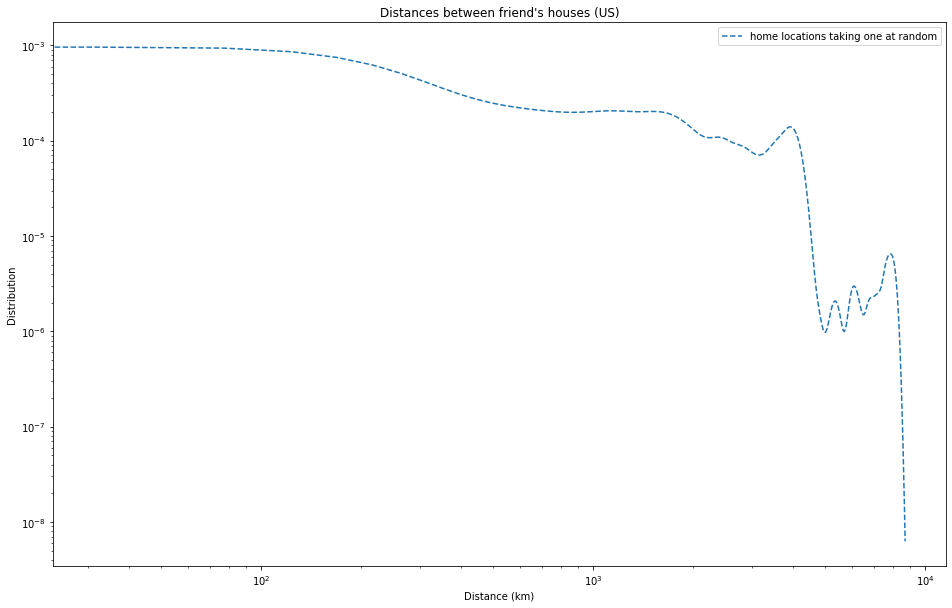

In [12]:
# We compare the distance between houses with our two dataframes of houses locations.

fig, ax = plt.subplots(figsize = (16, 10))
sns.kdeplot(distance_db_avg["distance"],ax = ax, common_norm = True, fill = False, linestyle = "--", legend = True, label = 'home locations taking one at random')
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.title("Distances between friend's houses (US)")
plt.ylabel("Distribution")
plt.xlabel("Distance (km)")
ax.legend()
plt.show()